In [3]:
import os, sys
import pandas as pd
import numpy as np
from operator import itemgetter
import urllib
import pyodbc
import sqlalchemy
from sqlalchemy.engine import URL
from pymssql import connect
import toml

In [4]:
config = toml.load("configuration.toml")

In [5]:
config

{'survey_year': '(2021)', 'weight_col': 'hh_weight_2021'}

In [64]:
conn_string = "DRIVER={ODBC Driver 17 for SQL Server}; SERVER=AWS-PROD-SQL\Sockeye; DATABASE=Elmer; trusted_connection=yes"
sql_conn = pyodbc.connect(conn_string)
params = urllib.parse.quote_plus(conn_string)
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

person_df = pd.read_sql(
            sql="SELECT worker, telecommute_freq, mode_freq_2, "+config['weight_col']+", wbt_bikemore_1, wbt_bikemore_2,\
            wbt_bikemore_3, wbt_bikemore_4 FROM HHSurvey.v_persons WHERE survey_year IN "
            + config["survey_year"],
            con=engine,
        )

In [7]:
trip_df = pd.read_sql(
            sql="SELECT * FROM HHSurvey.v_trips WHERE survey_year IN "
            + config["survey_year"],
            con=engine,
        )

In [8]:
def create_df(df, groupby_col, weight_col):
    """Create dataframe of weighted and unweighted values for a single column."""

    df_wt = df.groupby(groupby_col).sum()[[weight_col]].reset_index()
    df_wt.rename(columns={weight_col:'weighted'}, inplace=True)
    df_count = df.groupby(groupby_col).count()[[weight_col]].reset_index()
    df_count.rename(columns={weight_col:'samples'}, inplace=True)

    df = df_wt.merge(df_count, on=groupby_col)
    df.index = df[groupby_col]
    df = df.drop(groupby_col, axis=1)

    return df

# Person
#### Willingness to Bike

In [9]:
# Filter for current non-biker population (someone who rides less than once per week)
# This will be the denominator to calcualte the percent of current non-riders that might bike
# with infrastructure improvements. 
non_biker_pop = person_df[~person_df['mode_freq_2'].isin([
    '1 day/week','2-4 days/week','5 days/week','6-7 days/week'
                            ])]

In [10]:
person_df['mode_freq_2'].unique()

array(['2-4 days/week', 'I never do this',
       'I do this, but not in the past 30 days', 'Missing: Skip Logic',
       '5 days/week', '1-3 times in the past 30 days', '1 day/week',
       '6-7 days/week'], dtype=object)

In [11]:
non_biker_pop[config["weight_col"]].sum()

3945070.5518

In [12]:
# Percent of potential cyclists who would ride if there was a bike lane serving their destination

# wbt_bikemore_1: Use more bike --  Shared use path or protected bike lane
# wbt_bikemore_2: Use more bike --  Neighborhood greenway
# wbt_bikemore_3: Use more bike --  Bike lane
# wbt_bikemore_4: Use more bike --  Shared roadway lane

In [13]:
df_1 = create_df(non_biker_pop, 'wbt_bikemore_1', config["weight_col"])
df_2 = create_df(non_biker_pop, 'wbt_bikemore_2', config["weight_col"])
df_3 = create_df(non_biker_pop, 'wbt_bikemore_3', config["weight_col"])
df_4 = create_df(non_biker_pop, 'wbt_bikemore_4', config["weight_col"])

In [14]:
df_tot = df_1[['weighted']].merge(df_2[['weighted']], 
    left_index=True, right_index=True, suffixes=['_1','_2'])
df_tot = df_tot.merge(df_3[['weighted']], 
    left_index=True, right_index=True)
df_tot = df_tot.merge(df_4[['weighted']], 
    left_index=True, right_index=True, suffixes=['_3','_4'])

In [15]:
df_samples = df_1[['samples']].merge(df_2[['samples']], 
    left_index=True, right_index=True, suffixes=['_1','_2'])
df_samples = df_samples.merge(df_3[['samples']], 
    left_index=True, right_index=True)
df_samples = df_samples.merge(df_4[['samples']], 
    left_index=True, right_index=True, suffixes=['_3','_4'])

<AxesSubplot:ylabel='wbt_bikemore_1'>

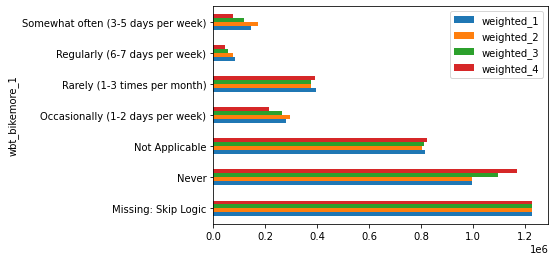

In [16]:
df_tot.plot(kind='barh')

In [17]:
# Group responses based on any positive answer (1 or more days per week)
df_grouped = pd.DataFrame(df_tot[df_tot.index.isin(['Occasionally (1-2 days per week)',
                            # 'Rarely (1-3 times per month)',
                            'Regularly (6-7 days per week)',
                            'Somewhat often (3-5 days per week)'])].sum(axis=0), columns=['Weighted'])

In [18]:
# Group responses based on any positive answer (1 or more days per week)
df_grouped_samples = pd.DataFrame(df_samples[df_samples.index.isin(['Occasionally (1-2 days per week)',
                            # 'Rarely (1-3 times per month)',
                            'Regularly (6-7 days per week)',
                            'Somewhat often (3-5 days per week)'])].sum(axis=0), columns=['Samples'])

In [19]:
df_samples

,samples_1,samples_2,samples_3,samples_4
wbt_bikemore_1,,,,
Missing: Skip Logic,2452,2452,2452,2452
Never,1243,1199,1328,1462
Not Applicable,1172,1166,1190,1197
Occasionally (1-2 days per week),388,405,349,284
Rarely (1-3 times per month),507,504,494,492
Regularly (6-7 days per week),103,100,69,52
Somewhat often (3-5 days per week),183,222,166,109


In [20]:
df_grouped_samples.to_clipboard()

In [21]:
df_grouped['share'] = df_grouped['Weighted']/non_biker_pop[config["weight_col"]].sum()
df_grouped

,Weighted,share
weighted_1,509774.2175,0.129218
weighted_2,540155.2480,0.136919
weighted_3,435331.7180,0.110348
weighted_4,331862.8298,0.084121


In [22]:
df_grouped.to_clipboard()


In [76]:
# percent of population who are commuters
# Commuters defined as all workers except frequent telecommuters; 
# ([number of workers in region]-[workers who telecommute 5+ times per week])/(total regional population)
total_workers = person_df.loc[person_df['worker'] == '1+ job(s) (including part-time)', config["weight_col"]].sum()
telecommuters = person_df.loc[person_df['telecommute_freq'] == '5+ days', config["weight_col"]].sum()
total_pop = person_df[config["weight_col"]].sum()

(total_workers-telecommuters)/total_pop

0.49601540223981705

# Trip

In [23]:
trip_wt = 'trip_respondent_weight_2021'

In [24]:
trip_df['wt_dist'] = trip_df['trip_path_distance']*trip_df[trip_wt]

In [25]:
# Average transit trip length
transit_df = trip_df[trip_df['mode_simple'] == 'Transit']
transit_df['wt_dist'].sum()/transit_df[trip_wt].sum()

8.221775526487507

In [26]:
# Average transit trip length *bus only
bus_df = trip_df[trip_df['mode_1'] == 'Bus (public transit)']
bus_df['wt_dist'].sum()/bus_df[trip_wt].sum()

7.848450226532842

In [61]:
# Average auto occupancy
# (total auto trips as driver or passenger)/(total auto trips as driver only)
(trip_df[trip_df['mode_simple'] == 'Drive'][trip_wt].sum())/trip_df[(trip_df['mode_simple'] == 'Drive') & 
                                                                    (trip_df['driver'] == 'Driver')][trip_wt].sum()


1.2816976836139036

In [28]:
# Average bicycle commute mode share
commute_df = trip_df[trip_df['dest_purpose'].isin(['Went to primary workplace'])]
commute_df[commute_df['mode_simple'] == 'Bike'][trip_wt].sum()/commute_df[trip_wt].sum()

0.024257933294634795

In [29]:

# Average pedestrian commute mode share
commute_df[commute_df['mode_simple'] == 'Walk'][trip_wt].sum()/commute_df[trip_wt].sum()

0.02792453078893675

In [30]:
# Average bicycle mode share for non-commute trips
non_commute_df = trip_df[~trip_df['dest_purpose'].isin(['Went to primary workplace'])]
non_commute_df[non_commute_df['mode_simple'] == 'Bike'][trip_wt].sum()/non_commute_df[trip_wt].sum()

0.010448942712029148

In [31]:
# Average pedestrian mode share for non-commute trips
non_commute_df[non_commute_df['mode_simple'] == 'Walk'][trip_wt].sum()/non_commute_df[trip_wt].sum()

0.1612448595635057

In [33]:
# Percent of travelers who are potential bicyclists


In [34]:
# Percent of travelers who are potential pdestrians


In [35]:
# Average bicycle trip length
bike_df = trip_df[trip_df['mode_simple'] == 'Bike']
bike_df['wt_dist'].sum()/bike_df[trip_wt].sum()

3.609866615770566

95th percentile distance:  1.9670000000000005
avg walk distance:  0.5738850736494415


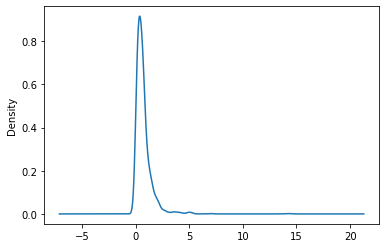

In [37]:
# Average pedestrian trip length
walk_df = trip_df[trip_df['mode_simple'] == 'Walk']

# Exclude trips to exercise and trips that have the same origin and destination parcel
walk_df = walk_df[walk_df['dest_purpose_cat'] != 'Social/Recreation']

# Exclude trips to and from same parcel
walk_df = walk_df[walk_df['origin_parcel_dim_id'] != walk_df['dest_parcel_dim_id']]

walk_df['trip_path_distance'].plot.kde()

# Exclude long tail of trips; find the 95th percentile distance (95% of trips shorter than this distance)
percentile_95 = walk_df['trip_path_distance'].describe(percentiles=[0.95])['95%']
print("95th percentile distance: ", percentile_95)
walk_df = walk_df[walk_df['trip_path_distance'] < percentile_95]

avg_dist = walk_df['wt_dist'].sum()/walk_df[trip_wt].sum()
print("avg walk distance: ", avg_dist)

In [38]:
trip_df['origin_purpose_cat'].unique()

array(['Home', 'Meal', 'Shop', 'Social/Recreation', 'Errand/Other',
       'Work', 'Escort', 'Work-related', 'School', 'Change mode'],
      dtype=object)

In [39]:
# Average number of non-commute trips per day

noncommute_df = trip_df[~((trip_df['origin_purpose_cat'] == 'Home') & (trip_df['dest_purpose_cat'] == 'Work'))]
noncommute_df = noncommute_df[~((noncommute_df['dest_purpose_cat'] == 'Home') & 
                                (noncommute_df['origin_purpose_cat'] == 'Work'))]
noncommute_df['dest_purpose_cat'].unique()


noncommute_df.groupby(['person_id','daynum']).count()[['trip_respondent_weight_2021']].mean()

# trip_df['']

trip_respondent_weight_2021    3.416752
dtype: float64

In [40]:
trip_df.groupby(['person_id','daynum']).count()[['trip_respondent_weight_2021']].mean()

trip_respondent_weight_2021    3.388921
dtype: float64

In [41]:
# Calculate regional mode shares

# Calculate hov2 and hov3 modes

# car_trip_df = trip_df.loc[trip_df['mode_simple'] == 'Drive']
trip_df['new_mode'] = trip_df['mode_simple']
trip_df.loc[(trip_df['travelers_total'] == 1) & (trip_df['mode_simple'] == 'Drive'), 'new_mode'] = 'SOV'
trip_df.loc[(trip_df['travelers_total'] == 2) & (trip_df['mode_simple'] == 'Drive'), 'new_mode'] = 'HOV2' 
trip_df.loc[(trip_df['travelers_total'] > 2) & (trip_df['mode_simple'] == 'Drive'), 'new_mode'] = 'HOV3+'

trip_df.groupby('new_mode').sum()[trip_wt]/trip_df[trip_wt].sum()

new_mode
Bike       0.011671
HOV2       0.195023
HOV3+      0.092778
Other      0.010919
SOV        0.510832
Transit    0.028827
Walk       0.149447
Name: trip_respondent_weight_2021, dtype: float64

In [43]:
# Average commute trip length
commute_df['trip_path_distance'].mean()

10.291568832717191

10.291568832717191

In [ ]:
# HOV eligible mode share along corridor (2)

In [ ]:
# HOV eligible mode share along corridor (3_)

In [454]:
# Average commute trip length
commute_df = trip_df[((trip_df['origin_purpose_cat'] == 'Home') & (trip_df['dest_purpose_cat'] == 'Work'))]
commute_df['wt_dist'].sum()/commute_df[trip_wt].sum()

10.93586442037644

In [ ]:
# Percent of potential pedestrians who would walk if there was a sidewalk serving their destination

# Dropped in 2017
# Can consider adding for 2025 with note to not include for other years? 